In [36]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
import os
import json
from collections import OrderedDict

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import h5py
import dill
from tqdm import tqdm
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
from scipy.interpolate import interp1d


In [38]:
from agnfinder.prospector import main, load_photometry
from agnfinder import photometry_to_table

In [39]:
from agnfinder.tf_sampling import deep_emulator, api, run_sampler

In [40]:
DATA_ROOT='/home/walml/repos/agnfinder/data'

In [41]:
parquet_loc = os.path.join(DATA_ROOT, 'cpz_paper_sample_week3_maggies.parquet')

In [42]:
# df = pd.read_parquet(parquet_loc, columns=metadata_cols + unified_cols)
df = pd.read_parquet(parquet_loc)
df = df[~pd.isnull(df['redshift'])].query('redshift > 1e-2').query('redshift < 4')

In [43]:
reliable_df = photometry_to_table.get_table(df, reliable=False, errors=True)

KeyboardInterrupt: 

In [ ]:
reliable_df.to_parquet(os.path.join(DATA_ROOT, 'photometry_quicksave.parquet'), index=False)

In [45]:
reliable_df = pd.read_parquet(os.path.join(DATA_ROOT, 'photometry_quicksave.parquet'))

In [46]:
len(reliable_df)

31986

In [47]:
reliable_df = reliable_df.dropna(how='any')

In [48]:
reliable_df.head(5)

,u_sloan,g_sloan,r_sloan,i_sloan,z_sloan,VISTA_H,VISTA_J,VISTA_Ks,VISTA_Y,VISTA_Z,...,r_sloan_err,i_sloan_err,z_sloan_err,VISTA_H_err,VISTA_J_err,VISTA_Ks_err,VISTA_Y_err,VISTA_Z_err,wise_w1_err,wise_w2_err
0,1.781900e-08,5.375302e-08,7.967488e-08,1.087319e-07,1.267261e-07,1.256065e-07,1.143024e-07,1.108993e-07,1.171704e-07,1.088652e-07,...,6.964999e-10,1.008546e-09,3.785472e-09,4.590286e-09,3.994510e-09,5.196076e-09,2.676763e-09,1.485159e-09,2.328079e-09,3.201664e-09
1,1.186709e-08,6.032281e-08,1.438846e-07,2.069894e-07,2.770264e-07,2.650874e-07,1.942970e-07,2.946234e-07,2.087550e-07,1.772930e-07,...,9.998342e-10,1.436723e-09,4.992107e-09,4.992156e-09,5.311614e-09,5.873228e-09,3.029148e-09,1.615531e-09,3.684516e-09,3.982414e-09
2,2.057348e-09,1.378700e-08,6.025764e-08,1.033550e-07,1.505270e-07,2.266809e-07,1.714673e-07,2.697247e-07,1.424872e-07,1.221603e-07,...,5.787670e-10,8.563322e-10,2.915427e-09,4.724336e-09,3.755588e-09,4.863245e-09,2.473786e-09,1.372283e-09,4.327562e-09,4.406147e-09
3,2.150587e-08,6.545114e-08,1.140264e-07,1.509821e-07,1.807405e-07,1.783612e-07,1.612472e-07,1.766664e-07,1.641209e-07,1.414613e-07,...,8.600254e-10,1.230467e-09,4.671726e-09,4.942027e-09,4.233929e-09,5.821705e-09,3.039470e-09,1.598205e-09,2.811742e-09,3.454457e-09
4,4.832349e-09,2.694458e-08,9.828532e-08,1.522470e-07,2.075978e-07,3.307775e-07,2.522924e-07,3.963731e-07,2.088120e-07,1.741281e-07,...,6.329587e-10,9.196589e-10,3.028876e-09,5.257536e-09,3.775976e-09,5.553676e-09,2.817053e-09,1.520309e-09,4.918398e-09,4.790533e-09


Text(0, 0.5, 'u_sloan_err')

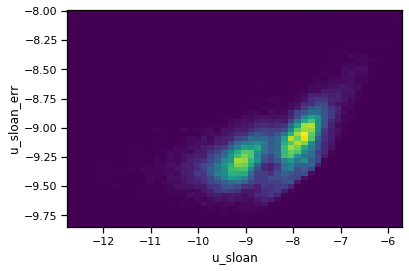

In [49]:
plt.hist2d(np.log10(reliable_df['u_sloan']), np.log10(reliable_df['u_sloan_err']), bins=[50, 50])
# plt.xlim([-11, -6])
# plt.ylim([-9, -8])
plt.xlabel('u_sloan')
plt.ylabel('u_sloan_err')

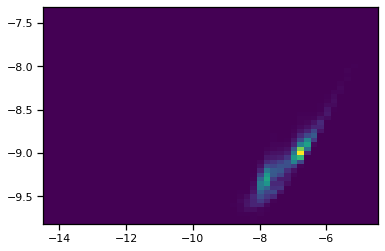

In [50]:
_ = plt.hist2d(np.log10(reliable_df['i_sloan']), np.log10(reliable_df['i_sloan_err']), bins=[50, 50])

Text(0, 0.5, 'log VISTA_J maggies err')

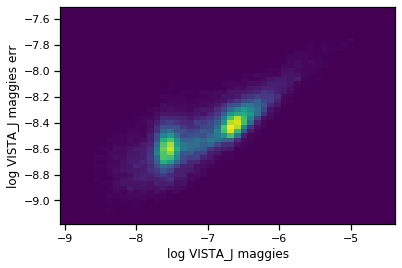

In [51]:
_ = plt.hist2d(np.log10(reliable_df['VISTA_J']), np.log10(reliable_df['VISTA_J_err']), bins=[50, 50])
plt.xlabel('log VISTA_J maggies')
plt.ylabel('log VISTA_J maggies err')

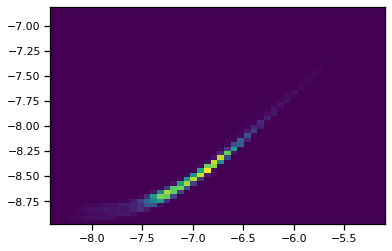

In [52]:
_ = plt.hist2d(np.log10(reliable_df['wise_w1']), np.log10(reliable_df['wise_w1_err']), bins=[50, 50])

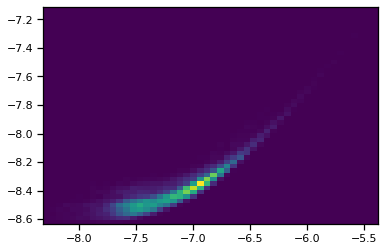

In [53]:
h, x, y, im = plt.hist2d(np.log10(reliable_df['wise_w2']), np.log10(reliable_df['wise_w2_err']), bins=[50, 50])

In [54]:
def log_space_fit(x, y, visualise=False):
    # x, y in real space, do fit in log space, give answers back in real space
    z = lowess(np.log10(y), np.log10(x))  # y, x format
    x_pred = z[:, 0]
    y_pred = z[:, 1]
    if visualise:
        plt.scatter(x=x_pred, y=y_pred, alpha=0.02)
#     interp = interp1d(x_pred, y_pred, bounds_error=False, fill_value=np.inf)
    interp = interp1d(x_pred, y_pred, bounds_error=False, fill_value='extrapolate')
    return lambda x: 10 ** interp(np.log10(x))

In [55]:
bands = reliable_df.columns.values[:12]
errors = reliable_df.columns.values[12:]
# 11 bands, hardcoded for now
bands, errors

(array(['u_sloan', 'g_sloan', 'r_sloan', 'i_sloan', 'z_sloan', 'VISTA_H',
        'VISTA_J', 'VISTA_Ks', 'VISTA_Y', 'VISTA_Z', 'wise_w1', 'wise_w2'],
       dtype=object),
 array(['u_sloan_err', 'g_sloan_err', 'r_sloan_err', 'i_sloan_err',
        'z_sloan_err', 'VISTA_H_err', 'VISTA_J_err', 'VISTA_Ks_err',
        'VISTA_Y_err', 'VISTA_Z_err', 'wise_w1_err', 'wise_w2_err'],
       dtype=object))

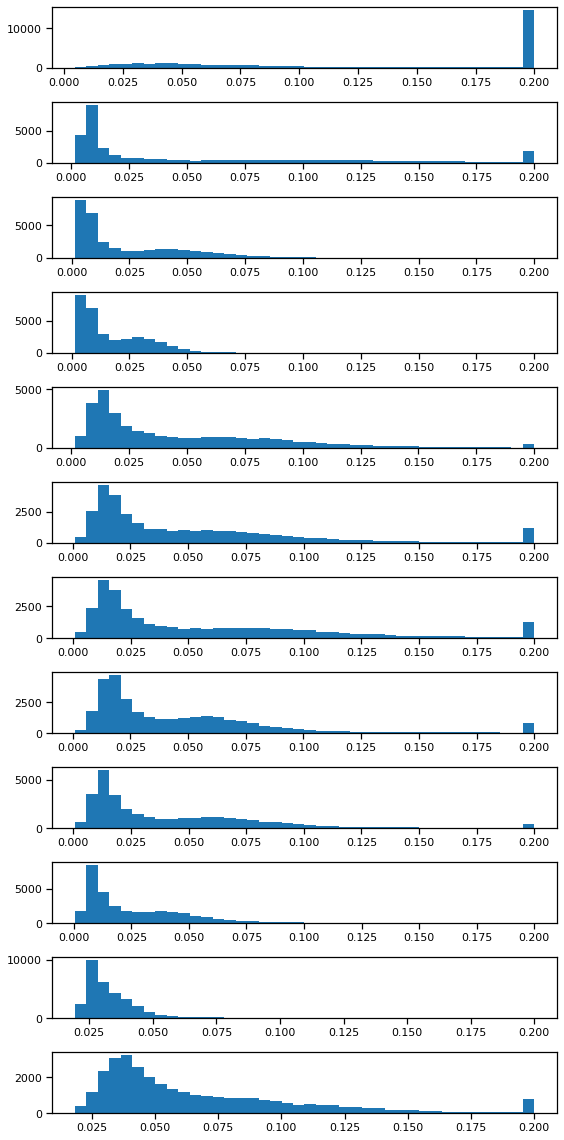

In [59]:
fig, axes = plt.subplots(nrows=len(bands), figsize=(8, 16))
for n, (band, error) in enumerate(zip(bands, errors)):
    relative_error = reliable_df[error] / reliable_df[band]
    ceiling_error = np.min(np.stack([relative_error, np.ones_like(relative_error) * 0.2]), axis=0)
    axes[n].hist(ceiling_error, bins=40)
fig.tight_layout()

In [31]:
best_fit = log_space_fit(reliable_df['u_sloan'], reliable_df['u_sloan_err'], visualise=False)

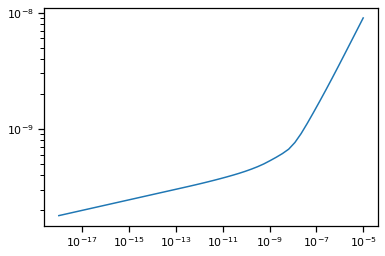

In [33]:
x = np.logspace(-18, -5)
y = best_fit(x)
plt.loglog(x, y)

In [ ]:
assert False  # slow after here

In [34]:
error_estimators = OrderedDict()
for band in tqdm(bands):
    error_estimators[band] = log_space_fit(reliable_df[band], reliable_df[band + '_err'])

100%|██████████| 12/12 [11:57<00:00, 59.82s/it]


In [35]:
# for testing here only, use error_estimators directly in practice
def get_sigma(x, error_estimators):
    return np.array([error_estimators[band](x[n]) for n, band in enumerate(error_estimators.keys())])

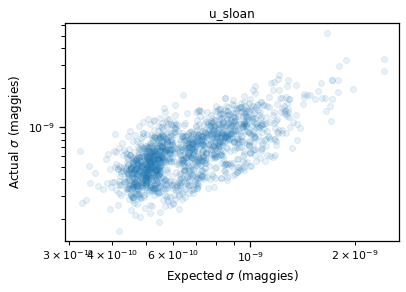

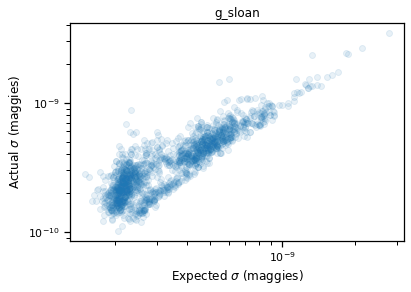

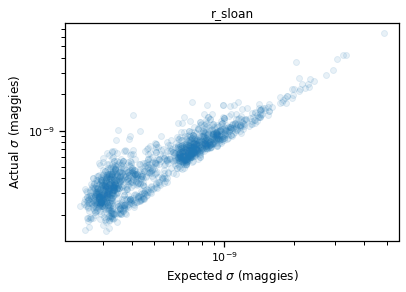

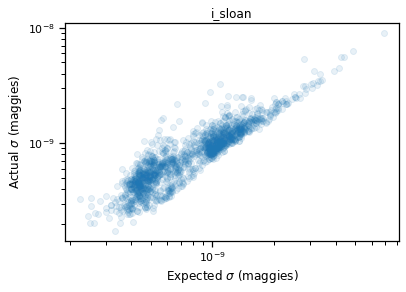

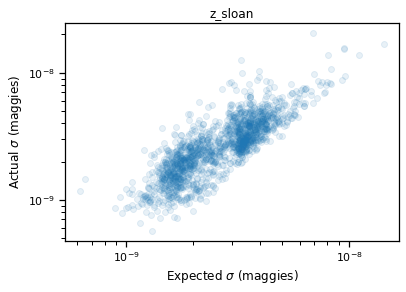

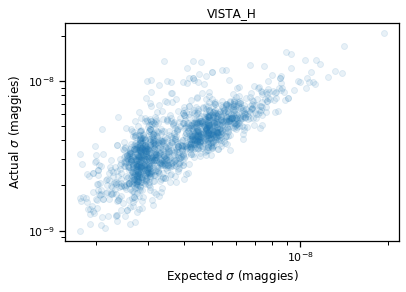

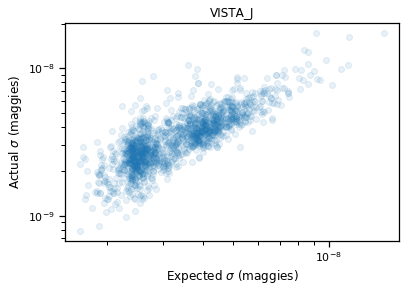

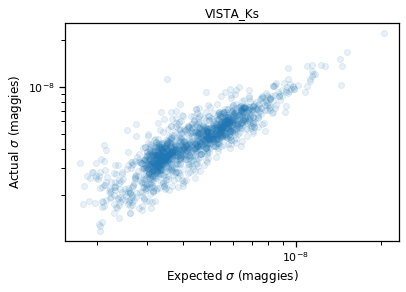

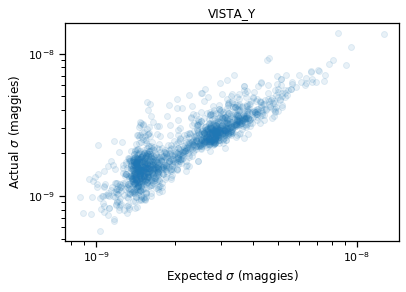

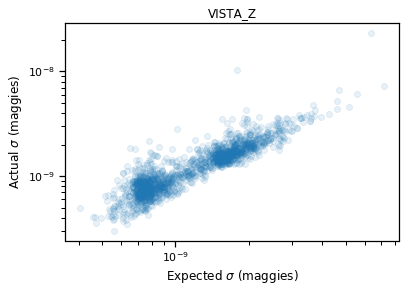

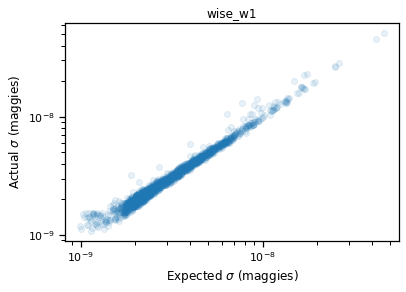

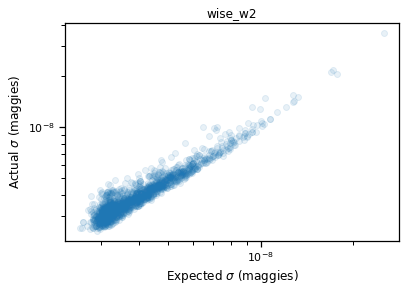

<Figure size 432x288 with 0 Axes>

In [37]:
n_galaxies = 1500
expected = np.zeros((n_galaxies, len(errors)))
actual = np.zeros((n_galaxies, len(errors)))
for n in range(n_galaxies):
    galaxy = reliable_df.sample().squeeze()
    photometry = galaxy[bands]
    expected[n] = get_sigma(photometry, error_estimators)
    actual[n] = galaxy[errors]
for band_n, band in enumerate(error_estimators.keys()):
    plt.loglog(expected[:, band_n], actual[:, band_n], 'o', alpha=0.1)
    plt.xlabel(r'Expected $\sigma$ (maggies)')
    plt.ylabel(r'Actual $\sigma$ (maggies)')
    plt.title(band)
    plt.figure()

In [38]:
!pwd

/home/mike/repos/agnfinder/notebooks/data_exploration


In [39]:
# with open('../../data/get_sigma.pickle', 'wb') as f:
#     dill.dump(get_sigma, f)
error_estimators_loc = '../../data/error_estimators.pickle'
with open(error_estimators_loc, 'wb') as f:
    dill.dump(error_estimators, f)

In [54]:
with open(error_estimators_loc, 'rb') as f:
    error_estimators_loaded = dill.load(f)

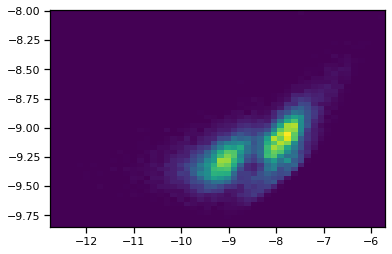

In [58]:
_ = plt.hist2d(x=np.log10(reliable_df['u_sloan']),y=np.log10(reliable_df['u_sloan_err']), bins=[50, 50])

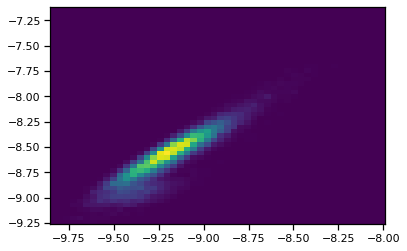

In [59]:
_ = plt.hist2d(np.log10(reliable_df['u_sloan_err']), np.log10(reliable_df['z_sloan_err']), bins=[50, 50])

In [4]:
from agnfinder.tf_sampling import hmc

In [5]:
os.chdir('/home/walml/repos/agnfinder')

In [6]:
params = ['mass', 'dust2', 'tage', 'tau', 'agn_disk_scaling', 'agn_eb_v', 'agn_torus_scaling']